# Table Of Contents :

    1. Understanding Business Problem
    2. Exploratory Data Analysis - EDA
    3. Cleaning Data
    4. Pre-proccessing Data
    5. Feature Selection
    6. Modelling
    7. Conclusion

# Understanding Business Problem

The aim of the project is to predict Uber trip fare by applying **Linear Models** . 

**Objective :**
    * Understand the dataset & cleanup (if required).
    * Build Linear Regression models to predict the fare price of uber ride.
    * Also evaluate the models & compare thier respective scores like R2, RMSE, etc.
 
**Data Location :** https://www.kaggle.com/datasets/yasserh/uber-fares-dataset

**Data Description :**
The dataset contains following fields:

    key : a unique identifier for each trip

    fare_amount : the cost of each trip in usd

    pickup_datetime : date and time when the meter was engaged

    passenger_count : the number of passengers in the vehicle (driver entered value)

    pickup_longitude : the longitude where the meter was engaged

    pickup_latitude : the latitude where the meter was engaged

    dropoff_longitude : the longitude where the meter was disengaged

    dropoff_latitude : the latitude where the meter was disengaged


# Understanding Data

In [260]:
# Importing Libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import googlemaps as gmaps
import datetime as dt
import geopy.distance
import requests # to call the openmap/google apis
import json
# import gmaps

#Pandas Settings
pd.options.display.max_rows= 500
pd.options.display.max_columns = 100


from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm

In [261]:
# Reading Data
df_original = pd.read_csv('data/uber.csv')


In [262]:
df = df_original.copy()
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [263]:
# Dropping unnecesary columns 
df.drop(['Unnamed: 0', 'key'], axis=1, inplace=True)

In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        200000 non-null  float64
 1   pickup_datetime    200000 non-null  object 
 2   pickup_longitude   200000 non-null  float64
 3   pickup_latitude    200000 non-null  float64
 4   dropoff_longitude  199999 non-null  float64
 5   dropoff_latitude   199999 non-null  float64
 6   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 10.7+ MB


**Insigths :**
    
* There are 6 numeric and 1 object columns after dropping unnececary columns('Unnamed: 0' and 'key').

* There are 200000 samples.

* There are 2 NaN values. (They need to be removed.)
    
    

# Data  Cleaning

## Missing Values

In [265]:
# Checking missing values
df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [266]:
# Removing missing values
df = df.dropna()

## Outliers

In [267]:
# Checking Outliers
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000
mean,11.359892,-72.527631,39.935881,-72.525292,39.923890,1.684543
std,9.901760,11.437815,7.720558,13.117408,6.794829,1.385995
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


**Insights :** It seems there are outliers in 'fare amount' and 'passenger_count'  and location columns. We will look at them cloesly and will take an action.

In [268]:
# Latitude and longitude are a pair of numbers (coordinates) used to describe a position on the plane of a geographic coordinate system. 
# The numbers are in decimal degrees format and range from -90 to 90 for latitude and -180 to 180 for longitude.
# We will keep the latitude and longitude values in the range (-90,90) and  (-180,180) , respectively.

In [269]:
# removing inconsistent coordinate values
df = df[(df.pickup_latitude<90) & (df.dropoff_latitude<90) &
        (df.pickup_latitude>-90) & (df.dropoff_latitude>-90) &
        (df.pickup_longitude<180) & (df.dropoff_longitude<180) &
        (df.pickup_longitude>-180) & (df.dropoff_longitude>-180)]

In [270]:
# Checking outliers in the passenger_count field.
df['passenger_count'].value_counts()

1      138416
2       29427
5       14008
3        8881
4        4275
6        4271
0         708
208         1
Name: passenger_count, dtype: int64

In [271]:
# removing the records with 0 or 208 passenger_count.
df = df[(df.passenger_count != 0) & (df.passenger_count != 208)]

In [272]:
# checking outliers in fare_amount
df['fare_amount'].describe([0.01, 0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99]).T

count    199278.000000
mean         11.366671
std           9.910696
min         -52.000000
1%            3.300000
5%            4.100000
10%           4.500000
25%           6.000000
50%           8.500000
75%          12.500000
90%          20.500000
95%          30.330000
99%          53.369100
max         499.000000
Name: fare_amount, dtype: float64

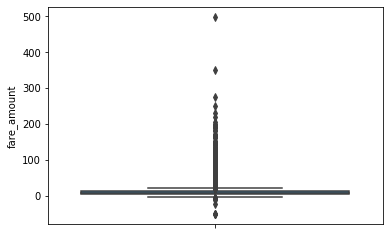

In [273]:
# visualize outliers in fare_amount field
sns.boxplot(y=df['fare_amount'])

In [274]:
# Remove the outliers in fare amoun field
Q1 = df['fare_amount'].quantile(0.01)
Q3 = df['fare_amount'].quantile(0.99)
    
IQR = Q3-Q1
    
upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR

df = df[(df['fare_amount'] < upper) & (df['fare_amount'] > lower)]


In [275]:
# Checking shape of the data after removing outliers and missing values
df.shape
print('Insgihts : In total {} records were deleted after missing value and outlier cleaning'.format(df_original.shape[0]-df.shape[0]))

Insgihts : In total 763 records were deleted after missing value and outlier cleaning


# Feature Engineering

## Creating New Features

We can get year, month, hour, day of week information from  'pickup_datetime' column. To do that we need to convert 'pickup_datetime' column to datetime object.

In [276]:
# Convert 'pickup_datetime ' dtype to datetime object
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

In [277]:
# Extract year, month, hour, day of week  information from pickup_datetime
df['year'] = df.pickup_datetime.dt.year
df['month'] = df.pickup_datetime.dt.month
df['hour'] = df.pickup_datetime.dt.hour
df['weekday'] = df.pickup_datetime.dt.weekday

# get month quarter
df['month_quarter'] = df.month.map({1:'Q1',2:'Q1',3:'Q1',4:'Q2',5:'Q2',6:'Q2',7:'Q3',
                                    8:'Q3',9:'Q3',10:'Q4',11:'Q4',12:'Q4'})

# split hours to 4 group
# H1 : 0,1,2,3,4,5 --> night hours
# H2 : 10,11,12,13,14,15 --> working hours [mid days]
# H3 : 6,7,8,9 16,17,18 --> before and after work hours
# H4 : 19,20,21,22,23 --> evening hours
df['hour_segment'] = df.hour.map({0:'H1',1:'H1',2:'H1',3:'H1',4:'H1',5:'H1',
                          10:'H2',11:'H2',12:'H2',13:'H2',14:'H2',15:'H2',
                          6:'H3',7:'H3',8:'H3',9:'H3',16:'H3',17:'H3',18:'H3',
                          19:'H4',20:'H4',21:'H4',22:'H4',23:'H4'})
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,hour,weekday,month_quarter,hour_segment
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,19,3,Q2,H4
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,20,4,Q3,H4
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,21,0,Q3,H4
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,8,4,Q2,H3
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,17,3,Q3,H3


In [278]:
# drop pickup_datetime
df.drop(['pickup_datetime'], axis=1, inplace=True)

In [279]:
# the straight distances between 2 coordinates
df['distance']=[round(geopy.distance.distance((df.pickup_latitude[i], df.pickup_longitude[i]),(df.dropoff_latitude[i], df.dropoff_longitude[i])).km,2) for i in df.index]

**Note :** Although the distance calculated here is not the driving distance, this feature has been created because it may have an effect on the price.

# EXPLORATORY DATA ANALYSIS (EDA)

In this section, the distribution of each feature, whether it has abnormal values, its relationship with other features, and dependent variable will be examined in order to better understand the data.

In [280]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,hour,weekday,month_quarter,hour_segment,distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,19,3,Q2,H4,1.68
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,20,4,Q3,H4,2.45
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,21,0,Q3,H4,5.04
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,8,4,Q2,H3,1.66
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,17,3,Q3,H3,4.48


In [281]:
# Checking the dtypes of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199237 entries, 0 to 199999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199237 non-null  float64
 1   pickup_longitude   199237 non-null  float64
 2   pickup_latitude    199237 non-null  float64
 3   dropoff_longitude  199237 non-null  float64
 4   dropoff_latitude   199237 non-null  float64
 5   passenger_count    199237 non-null  int64  
 6   year               199237 non-null  int64  
 7   month              199237 non-null  int64  
 8   hour               199237 non-null  int64  
 9   weekday            199237 non-null  int64  
 10  month_quarter      199237 non-null  object 
 11  hour_segment       199237 non-null  object 
 12  distance           199237 non-null  float64
dtypes: float64(6), int64(5), object(2)
memory usage: 26.3+ MB


In [282]:
# Checking number of unique rows
df.nunique().sort_values()

month_quarter            4
hour_segment             4
passenger_count          6
year                     7
weekday                  7
month                   12
hour                    24
fare_amount           1208
distance              2854
pickup_longitude     70985
dropoff_longitude    76794
pickup_latitude      83737
dropoff_latitude     90469
dtype: int64

**Insights:** There are 7 categorical columns. Dtypes of the columns passenger_count, year, weekday, month, hour are integer but when we checked the # of unique values that can be said that they are acually categorical feature.

## Univariate Analysis
### Exploring Target  Variable (fare_amount)

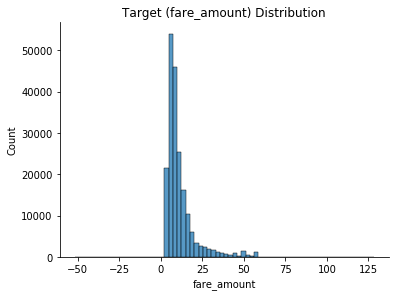

In [283]:
sns.displot(df['fare_amount'], aspect=1.4, bins=70,height=4)
plt.title('Target (fare_amount) Distribution')
plt.show()

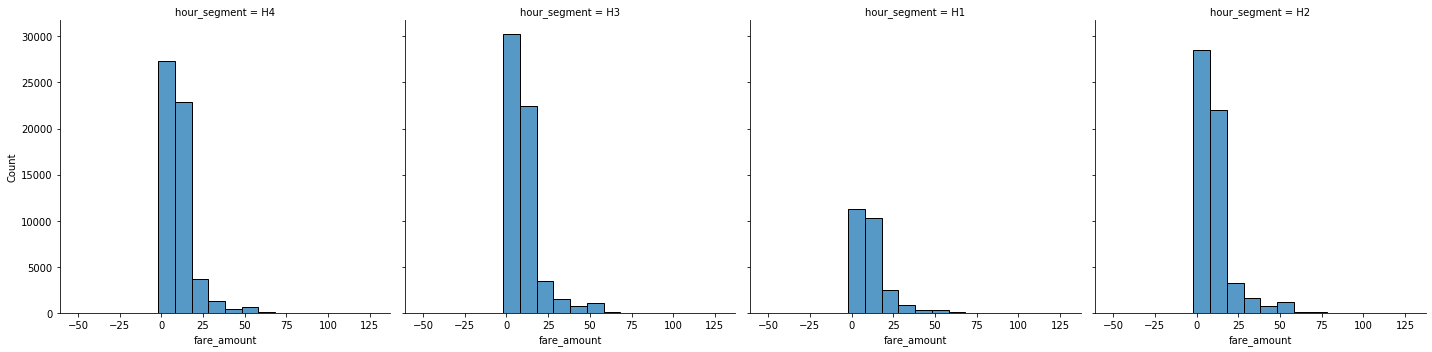

In [284]:
sns.displot(data=df, x='fare_amount', kind='hist', 
            bins=18, col='hour_segment')

**Insights:** fare_amount seems to be highly skewed, with most data points liening near 0.

### Exploring  Numeric Features

In [285]:
# distance distributions
sns.displot(df['distance'])
plt.title('Distribution of Distance')
plt.show()

KeyboardInterrupt: 

### Exploring Categoric Features

In [ ]:
for cat_col in ['month_quarter','hour_segment','passenger_count','year','weekday','month','hour']:
    sns.countplot(x=df[cat_col])
    plt.title('Distibutions of {}'.format(cat_col))
    plt.show()

**Insights :** 
    * According to the graphics, it is noteworthy that the taxi trips in 2015 were low.The low number of taxi trips in 2015 may be due to the lack of records for all months of that year. We can understand this by looking at the trip records for each month of that year. If there is such a situation, this may create an imbalance in our data set, so we can delete the records for this year. 

In [ ]:
# Check the monthly records for 2015.
df[df['year'] == 2015]['month'].unique()

**Insights :** It was observed that only the first 6 months of 2015 were recorded. For this reason, we can interpret the distribution of data more accurately by deleting the records for 2015. And then we need to run above code again to get more accurate visualization.

In [ ]:
# Delete record for year 2015
print(df.shape)
df = df[df['year'] != 2015] 
print(df.shape)

**Insights :** 
    * It was observed that taxi trips were relatively more intense in the second quarter of the year.
    
    * H3 hour_segment relatively most intense hours as they are the hours before and after work hours.
    
    * It is clear that taxi rides are usually with only one passenger.
    
    * The 4th day of the week seems to be the busiest day for taxi rides.
    
    * It can be said that the spring months are relatively busy in terms of taxi trips.
    
    * The intensity of taxi trip between the hours of 18 and 23 seems to be very high compared to other hours.

# Bivariate Analysis
In this section we will explore the relationships between the features and target.abs

In [ ]:
for cat_col in ['month_quarter','hour_segment','passenger_count','year','weekday','month','hour']:
    sns.catplot(x=cat_col, y='fare_amount', data=df)
    plt.title('Distibutions of {}'.format(cat_col))
    plt.show()

# Data Pre-Processing

In [ ]:
# Remove duplicates
df.drop_duplicates(inplace=True)

In [ ]:
# Remove coordinate columns as we already have distance column
df.drop(['pickup_latitude','pickup_longitude',
         'dropoff_latitude','dropoff_longitude'],axis=1,inplace=True)


In [ ]:
# check the shape after removing duplicates
df.shape

In [ ]:
# Convert categoric features that store as numeric to object
df[['year','weekday','passenger_count','month_quarter','hour_segment']]= df[['year','weekday','passenger_count','month_quarter','hour_segment']].astype(str)

In [ ]:
df.info()

In [ ]:
# Converting categorical columns to numeric - one hot encoding
df = pd.get_dummies(df,drop_first=True)

In [ ]:
df.head()

In [ ]:
# Splitting target and features
X = df.drop(['fare_amount'],axis=1)
Y = df['fare_amount']

In [ ]:
# split train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42)


In [ ]:
# Feature Scaling
std = StandardScaler()
X_train_std = pd.DataFrame(std.fit_transform(X_train),columns=X.columns)
X_test_std = pd.DataFrame(std.transform(X_test),columns=X.columns)

In [ ]:
X_train_std.head()

In [ ]:
X_test_std.head()

# Feature Selection

In [ ]:
plt.figure(figsize=[24,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

**Insights:** It seems to be strong multi-correlation between features.

In [ ]:
#Linear Regression model with statsmodels
x = df[['distance','hour_segment_H3']] #df.drop(['fare_amount'],axis=1)
y = df['fare_amount']
x = sm.add_constant(x)

result = sm.OLS(y,x).fit()
print(result.summary())

In [ ]:
X= sm.add_constant(X_train_std)
Y= np.array(Y_train)

model = sm.OLS(Y,X)
results = model.fit()

print(results.summary())